In [31]:
import numpy as np
import seaborn as sns
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('default') # 使用默认样式
from tools_2D import *
from shape_fns import *
from Elements import *
from Mesh import create_mesh, Boundary
import pickle
from scipy.interpolate import griddata

with open("Data/data.pkl", "rb") as f:
    data_ori = pickle.load(f)
path = 'Data'

In [32]:
def draw(elements_list, dir ='xy',type = 'disp'):
    refine = 3
    global_min = min([np.min([test_element(xy[0], xy[1], dir, type) for xy in test_element.sample_points(refine)]) for test_element in elements_list])
    global_max = max([np.max([test_element(xy[0], xy[1], dir, type) for xy in test_element.sample_points(refine)]) for test_element in elements_list])
    for test_element in elements_list:
        test_inputs = test_element.sample_points(refine)
        test_mapping = test_element.mapping(test_inputs)
        test_output = [test_element(xy[0], xy[1],dir, type) for xy in test_inputs]
        test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)
        plt.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                    test_mapping[:, 0].max(),
                                    test_mapping[:, 1].min(),
                                    test_mapping[:, 1].max()),
                                    origin='lower', aspect='auto',
                                    interpolation='none', cmap='jet',
                                        vmin=global_min, vmax=global_max)
            # 绘制元素的边界
        vertices = test_element.vertices
        vertices = np.vstack([vertices, vertices[0]])  # 将第一个顶点再次添加到数组的末尾，以便封闭形状
        vertices_x, vertices_y = zip(*vertices)  # 解压顶点坐标
        plt.plot(vertices_x, vertices_y,  color='white', linewidth=0.7)  # 使用黑色线绘制边界，并使用小圆点表示顶点

    plt.xlim(0, 40)
    plt.ylim(0, 40)
    # Display the color bar
    plt.colorbar()
    plt.legend()
    if type == 'disp':
        type_str = 'U'
    elif type == 'strain':
        type_str = '\\epsilon'
    elif type == 'stress':
        type_str = '\\sigma'
    dir_str = "{ %s }" % dir
    plt.title(rf"${type_str}_{dir_str}$")
    plt.show()

def draw_exact(elements_list, a_b, dir ='x'):
    # Initialize global_min and global_max
    global_min = float('inf')
    global_max = float('-inf')

    # Loop over each element in the elements_list
    for test_element in elements_list:
        
        # Evaluate the exact_fn at each mapping point of the test_element
        values = []
        test_inputs = test_element.sample_points(refine)
        for xy in test_element.mapping(test_inputs):
            value = exact_fn(xy[0], xy[1], a_b, dir)
            values.append(value)
        
        # Find the minimum and maximum value for the current element
        local_min = np.min(values)
        local_max = np.max(values)
        
        # Update global_min and global_max
        if local_min < global_min:
            global_min = local_min
        if local_max > global_max:
            global_max = local_max

    global_min, global_max

    for i in range(len(elements_list)):
        test_element = elements_list[i]
        test_inputs = test_element.sample_points(refine)
        test_mapping = test_element.mapping(test_inputs)
        test_output = [exact_fn(xy[0], xy[1],a_b, dir) for xy in test_mapping]
        test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)
        plt.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                            test_mapping[:, 0].max(),
                                            test_mapping[:, 1].min(),
                                            test_mapping[:, 1].max()),
                                            origin='lower', aspect='auto',
                                            interpolation='bilinear',cmap='jet',
                                            vmin=global_min, vmax=global_max)
        # 绘制元素的边界
        vertices = test_element.vertices
        vertices = np.vstack([vertices, vertices[0]])  # 将第一个顶点再次添加到数组的末尾，以便封闭形状
        vertices_x, vertices_y = zip(*vertices)  # 解压顶点坐标
        plt.plot(vertices_x, vertices_y,  color='white', linewidth=0.5)  # 使用黑色线绘制边界，并使用小圆点表示顶点s
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    # Display the color bar
    plt.colorbar()
    dir_str = "{ %s }" % dir
    plt.title(rf"Exact solution: $\sigma_{dir_str}$")
    plt.show()

a_b 0.05
mesh_size 4
mesh_shape T3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


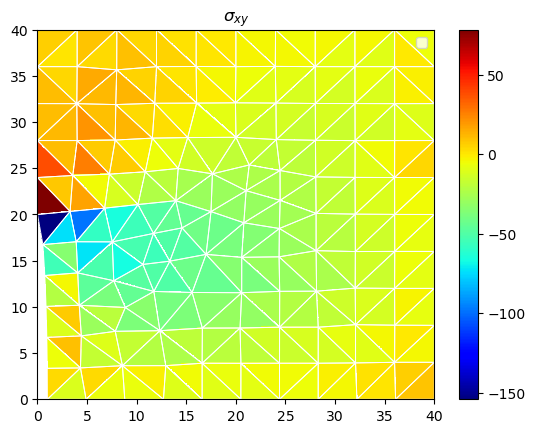

In [33]:
dir ='x'
type = 'strain'
if type == 'disp':
    type_str = 'U'
elif type == 'strain':
    type_str = '\\epsilon'
elif type == 'stress':
    type_str = '\\sigma'
dir_str = "{ %s }" % dir
iii = -4
refine = 10
elements_list = data_ori[iii]['elements_list']
a_b =data_ori[iii]['a_b'] 
data_keys = list(data_ori[iii].keys())[:3]
for key in data_keys:
    print(key, data_ori[iii][key])

# draw(elements_list, dir, type)
# draw(elements_list, 'y', type)
draw(elements_list, 'xy', 'stress')


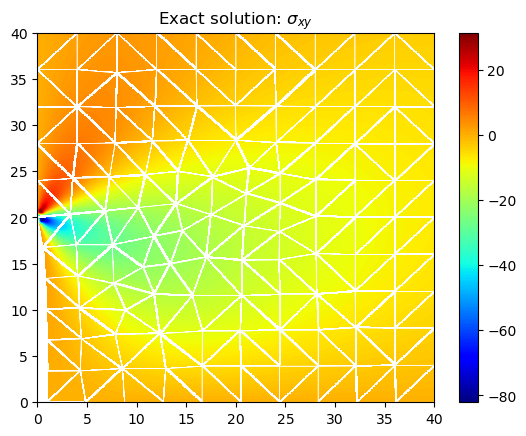

In [34]:
draw_exact(elements_list,a_b,'xy')

In [35]:
bugs

NameError: name 'bugs' is not defined

In [36]:


def cal_energy(elements_list, GPN = 2):
    E = 200e3
    nu = 0.3
    D = E / (1 - nu**2)* np.array([
        [1, nu, 0],
        [nu, 1, 0],
        [0, 0, (1-nu)/2]
        ])
    energy = 0
    for elem in elements_list:
        elem_energy = 0
        points, Ws = Gauss_points(elem, GPN)
        loop = 0
        scale = 4 if elem.shape=="triangle" else 1
        for g in range(len(Ws)):
            xy = points[g]
            W = Ws[g]
            strain_list = np.zeros((3,))
            strain_list[0] = elem(xy[0], xy[1], 'x', 'strain')
            strain_list[1] = elem(xy[0], xy[1], 'y', 'strain')
            strain_list[2] = elem(xy[0], xy[1], 'xy', 'strain')
            this_energy = 0.5 * W * strain_list.T @ D @ strain_list * scale
            stress_list = D @ strain_list
            elem_energy += this_energy 
            print(strain_list, stress_list)
            loop+=1
        energy+=elem_energy
    return energy

In [37]:
cal_energy(elements_list)

[ 0.000187   -0.00017137 -0.00048506] [ 29.80003595 -25.33373874 -37.31217176]
[ 0.000187   -0.00017137 -0.00048506] [ 29.80003595 -25.33373874 -37.31217176]
[ 0.000187   -0.00017137 -0.00048506] [ 29.80003595 -25.33373874 -37.31217176]
[ 0.00058906 -0.00024705 -0.00054127] [113.17388705 -15.45722037 -41.63648575]
[ 0.00058906 -0.00024705 -0.00054127] [113.17388705 -15.45722037 -41.63648575]
[ 0.00058906 -0.00024705 -0.00054127] [113.17388705 -15.45722037 -41.63648575]
[ 0.00020455 -0.00014267 -0.00044002] [ 35.54988989 -17.86944751 -33.84761742]
[ 0.00020455 -0.00014267 -0.00044002] [ 35.54988989 -17.86944751 -33.84761742]
[ 0.00020455 -0.00014267 -0.00044002] [ 35.54988989 -17.86944751 -33.84761742]
[ 0.0001831  -0.00023873 -0.00022948] [ 24.50200449 -40.3945362  -17.65243649]
[ 0.0001831  -0.00023873 -0.00022948] [ 24.50200449 -40.3945362  -17.65243649]
[ 0.0001831  -0.00023873 -0.00022948] [ 24.50200449 -40.3945362  -17.65243649]
[ 0.00038156 -0.00014948 -0.00056852] [ 74.00243332 

16.77322279902302

In [38]:


def cal_energy_exact(elements_list,a_b, GPN = 2):
    E = 200e3
    nu = 0.3
    D = E / (1 - nu**2)* np.array([
        [1, nu, 0],
        [nu, 1, 0],
        [0, 0, (1-nu)/2]
        ])
    energy = 0
    for elem in elements_list:
        elem_energy = 0
        points, Ws = Gauss_points(elem, GPN)
        xys = elem.mapping(points)
        loop = 0
        scale = 4 if elem.shape=="triangle" else 1
        for g in range(len(Ws)):
            xy = xys[g]
            W = Ws[g]
            # print(W, xy)
            stress_list = np.zeros((3,))
            stress_list[0] = exact_fn(xy[0], xy[1], a_b, 'x')
            stress_list[1] = exact_fn(xy[0], xy[1], a_b, 'y')
            stress_list[2] = exact_fn(xy[0], xy[1], a_b, 'xy')
            strain_list = np.linalg.inv(D) @ stress_list
            # this_energy = 0.5 * W * stress_list.T @ np.linalg.inv(D) @ stress_list * scale
            print(strain_list, stress_list)

            this_energy = 0.5 * W * strain_list.T @ D @ strain_list * scale
            elem_energy += this_energy 
            loop+=1
        energy+=elem_energy
    return energy
cal_energy_exact(elements_list, a_b)

[ 5.63825153e-05 -4.62479557e-05 -1.32789489e-04] [  9.34244583  -6.44685739 -10.21457611]
[ 5.48303322e-05 -5.63900949e-05 -1.43226646e-04] [  8.33259423  -8.77824072 -11.01743429]
[ 4.56293118e-05 -6.48240319e-05 -1.09167038e-04] [  5.75430819 -11.23851392  -8.3974645 ]
[ 2.11870632e-04 -8.53487446e-05 -2.31102483e-04] [ 40.93758441  -4.7884736  -17.77711407]
[ 2.31956588e-04 -9.32696983e-05 -2.07432529e-04] [ 44.82981935  -5.20499386 -15.95634841]
[ 0.00024534 -0.00010243 -0.00021714] [ 47.16687456  -6.33586338 -16.7032591 ]
[ 6.45686971e-05 -5.10641457e-05 -1.67549080e-04] [ 10.82405569  -6.96561242 -12.88839075]
[ 6.52776587e-05 -4.27171152e-05 -1.52252962e-04] [ 11.53022508  -5.08435552 -11.71176627]
[ 8.42958868e-05 -4.63977460e-05 -1.98479611e-04] [ 15.46737648  -4.63933626 -15.2676624 ]
[ 3.85006784e-05 -6.97998174e-05 -6.29486899e-05] [  3.85950179 -12.80211294  -4.84220692]
[ 5.03520244e-05 -4.75174663e-05 -1.11233423e-04] [ 7.93335922 -7.12348549 -8.55641718]
[ 4.19331309e-

3.0795412618259084

[11.01070541  7.83121925]
[9.26811776 9.08633375]
[8.76008952 7.7967457 ]
[17.71349472 17.02272186]
[19.61720587 18.7331934 ]
[17.96177099 19.33687423]
[9.91653965 9.80556506]
[11.6591273   8.55045055]
[11.35377708 10.67367091]
[9.07334367 4.88650512]
[10.96201189  6.78126209]
[8.71139599 6.74678854]
[16.65551054 12.24139352]
[19.15387094 12.22914591]
[17.35957564 14.30281622]
[17.10980218  8.98294425]
[19.09142758 10.89917792]
[16.59306718 10.91142553]
[18.80250713 27.68783545]
[16.37079441 27.67299954]
[17.61708976 25.71090452]
[16.55446786 30.81366082]
[16.10513893 28.94868862]
[18.53685166 28.96352453]
[5.05434027 4.01204998]
[7.16901652 4.13234765]
[5.09743184 5.7452133 ]
[20.67584943 24.7341867 ]
[18.82137011 24.25421529]
[20.51885388 23.34320216]
[19.83609869 27.19379425]
[18.65068131 25.21686331]
[20.50516063 25.69683472]
[5.6816747 6.405407 ]
[7.75325937 4.79254135]
[7.3913117  6.65282477]
[18.17909962 23.41282306]
[18.10676748 21.36861778]
[19.8765834  22.50180993]
[5.4165868

3.0795412618259084

In [ ]:

draw(elements_list, dir, type)

TypeError: 'int' object is not iterable

NameError: name 'N1' is not defined

2050.0


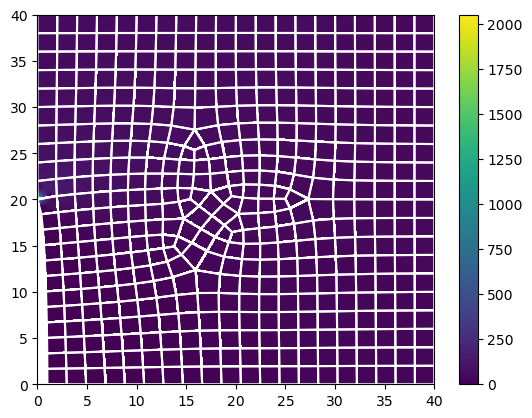

In [ ]:
stress = []
xys = []

global_min = min([np.min([exact_fn(xy[0], xy[1],data_ori[iii]['a_b'], dir) for xy in test_element.mapping(refine)]) for test_element in elements_list])
global_max = max([np.max([exact_fn(xy[0], xy[1],data_ori[iii]['a_b'], dir)for xy in test_element.mapping(refine)]) for test_element in elements_list])
print(global_max)
for i in range(len(elements_list)):
   test_element = elements_list[i]
   test_mapping = test_element.mapping(refine)
   test_output = [exact_fn(xy[0], xy[1],data_ori[iii]['a_b'], dir) for xy in test_mapping]
   test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)
   plt.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                    test_mapping[:, 0].max(),
                                    test_mapping[:, 1].min(),
                                    test_mapping[:, 1].max()),
                                    origin='lower', aspect='auto',
                                    interpolation='bilinear',
                                        vmin=global_min, vmax=global_max)
            # 绘制元素的边界
   vertices = test_element.vertices
   vertices = np.vstack([vertices, vertices[0]])  # 将第一个顶点再次添加到数组的末尾，以便封闭形状
   vertices_x, vertices_y = zip(*vertices)  # 解压顶点坐标
   plt.plot(vertices_x, vertices_y,  color='white')  # 使用黑色线绘制边界，并使用小圆点表示顶点s
plt.xlim(0, 40)
plt.ylim(0, 40)
# Display the color bar
plt.colorbar()


In [ ]:
print(data_ori[iii]['nodes_coord'])

[[1.00000000e+00 1.13570713e-13]
 [2.22044605e-15 2.00000000e+01]
 [0.00000000e+00 4.00000000e+01]
 [4.00000000e+01 4.00000000e+01]
 [4.00000000e+01 0.00000000e+00]
 [9.85876479e-01 3.34948159e+00]
 [9.42241114e-01 6.69870681e+00]
 [8.64655312e-01 1.00473119e+01]
 [7.42605883e-01 1.33945736e+01]
 [5.47335414e-01 1.67382669e+01]
 [9.08144932e-01 8.37311846e+00]
 [6.57610285e-01 1.50671658e+01]
 [8.10268175e-01 1.17211857e+01]
 [9.67933326e-01 5.02414474e+00]
 [3.91257191e-01 1.84056275e+01]
 [9.96487824e-01 1.67475579e+00]
 [0.00000000e+00 3.60000000e+01]
 [0.00000000e+00 3.20000000e+01]
 [0.00000000e+00 2.80000000e+01]
 [0.00000000e+00 2.40000000e+01]
 [0.00000000e+00 3.00000000e+01]
 [0.00000000e+00 3.40000000e+01]
 [0.00000000e+00 3.80000000e+01]
 [0.00000000e+00 2.60000000e+01]
 [0.00000000e+00 2.20000000e+01]
 [3.60000000e+01 4.00000000e+01]
 [3.20000000e+01 4.00000000e+01]
 [2.80000000e+01 4.00000000e+01]
 [2.40000000e+01 4.00000000e+01]
 [2.00000000e+01 4.00000000e+01]
 [1.600000

In [ ]:
elem = data_ori[iii]['elements_list'][12]
print(elem)
elem.mapping(3)

[[20.26362179 18.44044686]
 [20.70276521 20.18978641]
 [19.55722983 20.36570227]
 [18.73994463 19.51356347]]


array([[20.26362179, 18.44044686],
       [19.50178321, 18.97700516],
       [18.73994463, 19.51356347],
       [20.4831935 , 19.31511664],
       [19.81589036, 19.62737475],
       [19.14858723, 19.93963287],
       [20.70276521, 20.18978641],
       [20.12999752, 20.27774434],
       [19.55722983, 20.36570227]])

In [ ]:
jjj = np.zeros((5, 1))
jjj

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])